In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score


import matplotlib.pyplot as plt

In [3]:

labels = pd.read_csv('../data/Label.csv')
data = pd.read_csv('../data/Data.csv')

this is the data cleaning part

In [4]:
print("Data shape before processing:", data.shape)

# Check for missing values in each column
missing_values_column = data.isnull().sum()
if missing_values_column.sum() > 0:
    print("Columns with missing values:")
    print(missing_values_column[missing_values_column > 0])  # Display columns with missing values
else:
    print("No missing values found in the data.")

# Find the number of unique values in each column
unique_values = data.nunique()
print("Number of unique values in each column:")
print(unique_values)

# Drop columns with only one unique value
for col in data.columns:
    if data[col].nunique() == 1:
        data.drop(col, axis=1, inplace=True)
        print(f"Dropped column: {col}")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels['Label'], test_size=0.2, random_state=42)


Data shape before processing: (447915, 76)
No missing values found in the data.
Number of unique values in each column:
Flow Duration                 174373
Total Fwd Packet                 847
Total Bwd packets                928
Total Length of Fwd Packet      7697
Total Length of Bwd Packet      9322
                               ...  
Active Min                      1778
Idle Mean                       2280
Idle Std                         611
Idle Max                        2280
Idle Min                        2280
Length: 76, dtype: int64
Dropped column: Bwd PSH Flags
Dropped column: Fwd URG Flags
Dropped column: Bwd URG Flags
Dropped column: URG Flag Count
Dropped column: CWR Flag Count
Dropped column: ECE Flag Count
Dropped column: Fwd Bytes/Bulk Avg
Dropped column: Fwd Packet/Bulk Avg
Dropped column: Fwd Bulk Rate Avg


Feature selection with the help of random forest classifier

In [5]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Feature Importances:
                    Importance
Fwd Seg Size Min      0.088675
Bwd Packets/s         0.073857
Flow Packets/s        0.046659
FWD Init Win Bytes    0.044492
Fwd Packets/s         0.039724
Flow IAT Mean         0.036218
Fwd IAT Mean          0.030243
Flow IAT Std          0.027771
Down/Up Ratio         0.027197
Packet Length Max     0.026878


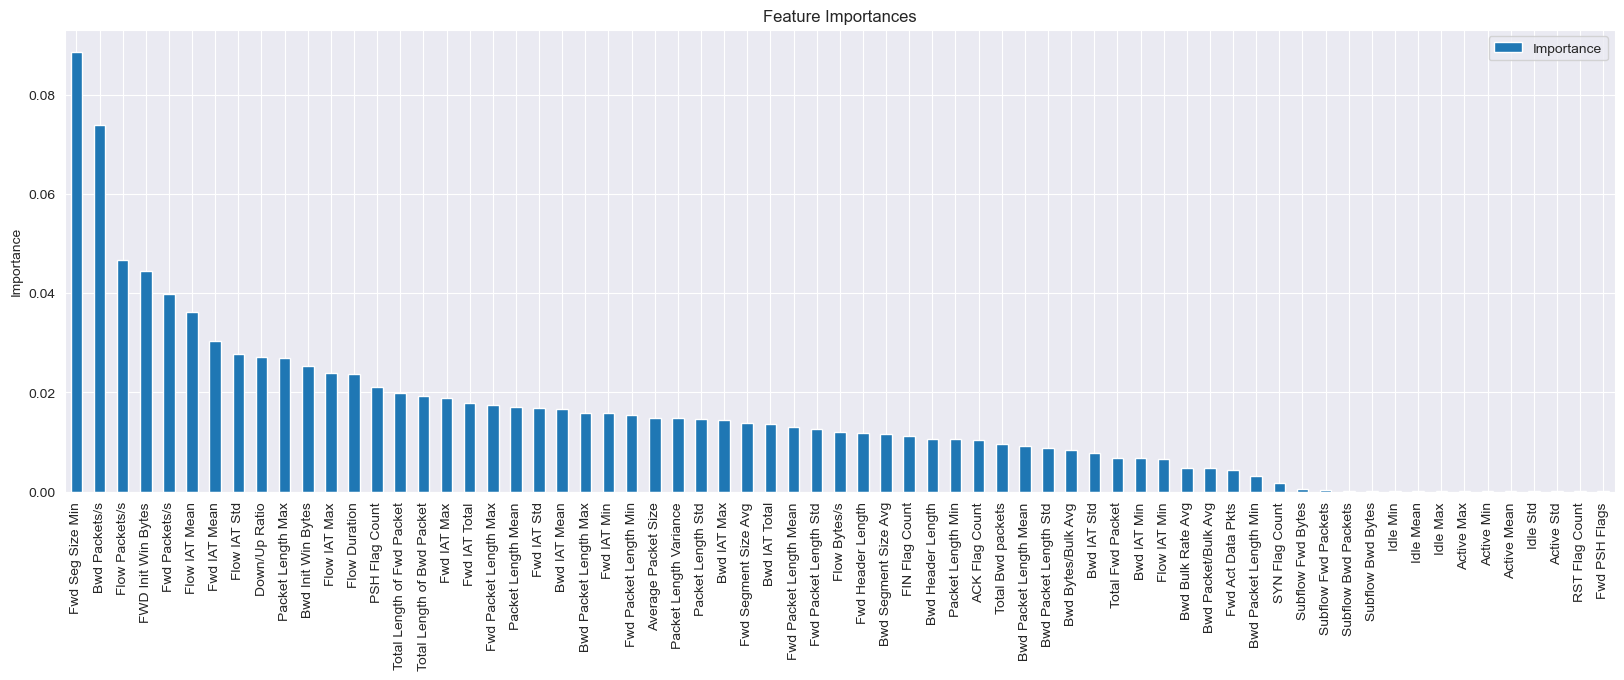

In [6]:
feature_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns, columns=['Importance'])

# Sort and display feature importances
print("Feature Importances:")
print(feature_importances.sort_values(by='Importance', ascending=False).head(10))

feature_importances.sort_values(by='Importance', ascending=False).plot(kind='bar', figsize=(20,6))
plt.title('Feature Importances')
plt.ylabel('Importance')
plt.show()


In [7]:
top_10_features = feature_importances.sort_values(by='Importance', ascending=False).head(10).index

In [8]:
X_train_top10 = X_train[top_10_features]
X_test_top10 = X_test[top_10_features]

classification using random forest classifier

In [9]:
rf_classifier = RandomForestClassifier(random_state=42)

In [10]:
rf_classifier.fit(X_train_top10, y_train)

RandomForestClassifier(random_state=42)

In [11]:
y_pred = rf_classifier.predict(X_test_top10)

Accuracy with top 10 features: 0.9173
Precision: 0.9165
Recall: 0.9173
F1-Score: 0.9154


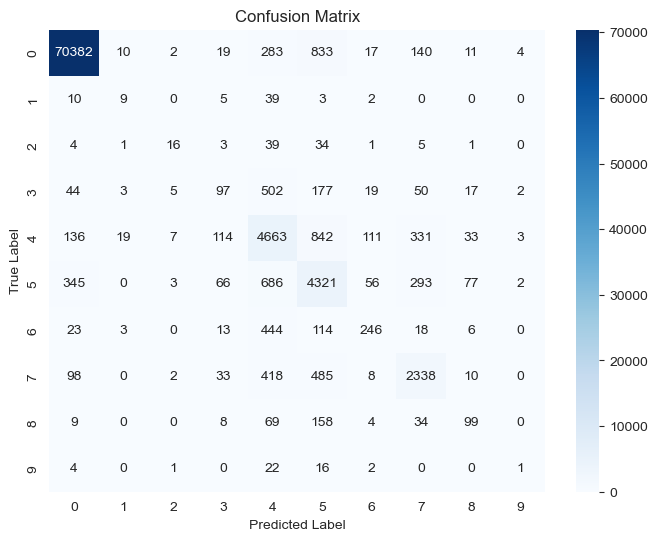

In [12]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with top 10 features: {accuracy:.4f}")  # Display accuracy with four decimal places

# Optional: Calculate additional evaluation metrics


precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print additional metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")



# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1-score for each label
precision = precision_score(y_test, y_pred, average=None, labels=labels['Label'].unique())
recall = recall_score(y_test, y_pred, average=None, labels=labels['Label'].unique())
f1 = f1_score(y_test, y_pred, average=None, labels=labels['Label'].unique())

# Print metrics for each label
for idx, label in enumerate(labels['Label'].unique()):
    print(f"Label: {label}")
    print(f"Precision: {precision[idx]:.4f}")
    print(f"Recall: {recall[idx]:.4f}")
    print(f"F1-Score: {f1[idx]:.4f}\n")


Label: 4
Precision: 0.6508
Recall: 0.7450
F1-Score: 0.6947

Label: 7
Precision: 0.7286
Recall: 0.6893
F1-Score: 0.7084

Label: 3
Precision: 0.2709
Recall: 0.1059
F1-Score: 0.1523

Label: 6
Precision: 0.5279
Recall: 0.2837
F1-Score: 0.3691

Label: 0
Precision: 0.9905
Recall: 0.9816
F1-Score: 0.9860

Label: 8
Precision: 0.3898
Recall: 0.2598
F1-Score: 0.3118

Label: 5
Precision: 0.6188
Recall: 0.7388
F1-Score: 0.6735

Label: 9
Precision: 0.0833
Recall: 0.0217
F1-Score: 0.0345

Label: 2
Precision: 0.4444
Recall: 0.1538
F1-Score: 0.2286

Label: 1
Precision: 0.2000
Recall: 0.1324
F1-Score: 0.1593



due to the lower recognition of some lables (we are going to oversample the data set)(oversample the attacks more)

In [25]:
smote = SMOTE(random_state=42,sampling_strategy = {
    1: 2000,   # Class 1 (originally 317) is oversampled to 2000
    2: 2000,   # Class 2 (originally 348) is oversampled to 2000
    3: 4000,   # Class 3 (originally 3551) is oversampled to 3000
    4: 25000,  # Class 4 (originally 24692) is kept nearly the same
    5: 25000,  # Class 5 (originally 23764) is kept nearly the same
    6: 4500,  # Class 6 (originally 3765) is oversampled to 10000
    7: 15000,  # Class 7 (originally 13343) is oversampled to 15000
    8: 2000,   # Class 8 (originally 1721) is oversampled to 5000
    9: 1000    # Class 9 (originally 200) is oversampled to 2000
})

In [26]:
X_resampled, y_resampled = smote.fit_resample(X_train_top10, y_train)

In [27]:
print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", pd.Series(y_resampled).value_counts())

Before SMOTE: Label
0    286631
4     24692
5     23764
7     13343
6      3765
3      3551
8      1721
2       348
1       317
9       200
Name: count, dtype: int64
After SMOTE: Label
0    286631
4     25000
5     25000
7     15000
6      4500
3      4000
8      2000
1      2000
2      2000
9      1000
Name: count, dtype: int64


In [29]:
rf_classifier = RandomForestClassifier(random_state=42)

In [30]:
rf_classifier.fit(X_resampled, y_resampled)

RandomForestClassifier(random_state=42)

In [31]:
y_pred = rf_classifier.predict(X_test_top10)

In [33]:


# Print overall accuracy
overall_accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {overall_accuracy:.4f}\n")

# Calculate precision, recall, and F1-score for each label
precision = precision_score(y_test, y_pred, average=None, labels=labels['Label'].unique())
recall = recall_score(y_test, y_pred, average=None, labels=labels['Label'].unique())
f1 = f1_score(y_test, y_pred, average=None, labels=labels['Label'].unique())

# Calculate accuracy for each label
accuracy_per_label = []
for label in labels['Label'].unique():
    label_correct = ((y_test == label) & (y_pred == label)).sum()  # Correct predictions for the label
    label_total = (y_test == label).sum()  # Total instances for the label
    accuracy = label_correct / label_total if label_total > 0 else 0  # Calculate accuracy
    accuracy_per_label.append(accuracy)

# Print metrics for each label
for idx, label in enumerate(labels['Label'].unique()):
    print(f"Label: {label}")
    print(f"Precision: {precision[idx]:.4f}")
    print(f"Recall: {recall[idx]:.4f}")
    print(f"F1-Score: {f1[idx]:.4f}")
    print(f"Accuracy: {accuracy_per_label[idx]:.4f}\n")

Overall Accuracy: 0.9158

Label: 4
Precision: 0.6569
Recall: 0.7250
F1-Score: 0.6893
Accuracy: 0.7250

Label: 7
Precision: 0.7190
Recall: 0.6946
F1-Score: 0.7066
Accuracy: 0.6946

Label: 3
Precision: 0.2678
Recall: 0.1070
F1-Score: 0.1529
Accuracy: 0.1070

Label: 6
Precision: 0.4902
Recall: 0.2872
F1-Score: 0.3622
Accuracy: 0.2872

Label: 0
Precision: 0.9909
Recall: 0.9814
F1-Score: 0.9861
Accuracy: 0.9814

Label: 8
Precision: 0.3647
Recall: 0.2546
F1-Score: 0.2998
Accuracy: 0.2546

Label: 5
Precision: 0.6189
Recall: 0.7292
F1-Score: 0.6695
Accuracy: 0.7292

Label: 9
Precision: 0.0877
Recall: 0.1087
F1-Score: 0.0971
Accuracy: 0.1087

Label: 2
Precision: 0.2524
Recall: 0.2500
F1-Score: 0.2512
Accuracy: 0.2500

Label: 1
Precision: 0.1771
Recall: 0.5000
F1-Score: 0.2615
Accuracy: 0.5000

